# 3x3 PPO

In [19]:
# imports 
from stable_baselines3 import DQN, PPO
import gymnasium as gym
import gym_gridworlds
from gym_gridworlds.observation_wrappers import MatrixWithGoalWrapper
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [20]:
# make environment
# logging wrapper
LOG_DIR = "logs/"
MODEL_DIR = "trained_models/"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Wrap the environment with Monitor to log training progress
env = gym.make("Gym-Gridworlds/Penalty-3x3-v0", no_stay=True, distance_reward=True, start_pos = None)
env = MatrixWithGoalWrapper(env)
env = Monitor(env, LOG_DIR)

In [21]:
# name = 'bssbs'
model = DQN(
    "MlpPolicy",
    env,
    learning_rate=0.004,
    n_steps = 128, 
    batch_size=32,
    gamma=0.98,
    exploration_fraction=0.07,
    verbose=1,
)


Using cpu device
Wrapping the env in a DummyVecEnv.


In [22]:
# train model, progress bar w tdqm
print("--- Starting Training ---")
model.learn(total_timesteps=30000, progress_bar=True)
print( "--- Training Finished ---")

/Users/alisonandrade/Desktop/gym_gridworlds/.venv/lib/python3.14/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

--- Starting Training ---
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.5      |
|    ep_rew_mean      | -30.7    |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5139     |
|    time_elapsed     | 0        |
|    total_timesteps  | 38       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | -56.4    |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1385     |
|    time_elapsed     | 0        |
|    total_timesteps  | 189      |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 14.7     |
|    n_updates        | 22       |
----------------------------------
----------------------------------
| rollout/            |      

--- Training Finished ---


In [23]:
model.save("trained_models/DQN_3x3")

In [24]:
eval_env = gym.make("Gym-Gridworlds/Penalty-3x3-v0", no_stay=True, distance_reward=True)
trained_model = PPO.load("trained_models/PPO_3x3")
mean_reward, std_reward = evaluate_policy(trained_model, eval_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: -0.67 +/- 0.00


/Users/alisonandrade/Desktop/gym_gridworlds/.venv/lib/python3.14/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


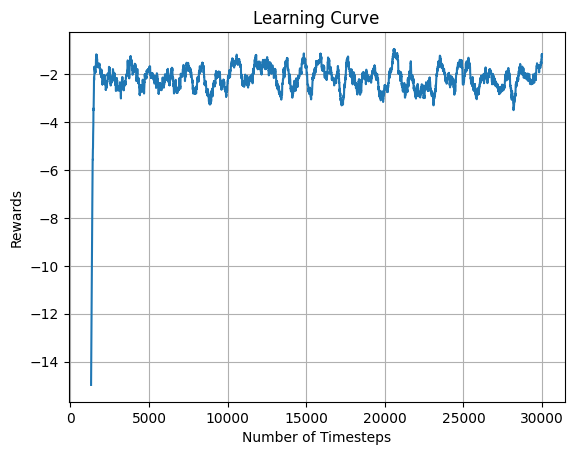

In [25]:
# Plotting the learning curve from the Monitor logs

# Helper function from Stable Baselines 3 to read monitor files
def plot_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    # Smooth the curve using a moving average
    y = np.convolve(y, np.ones(100)/100, mode='valid')
    x = x[len(x) - len(y):]
    
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_results(LOG_DIR)

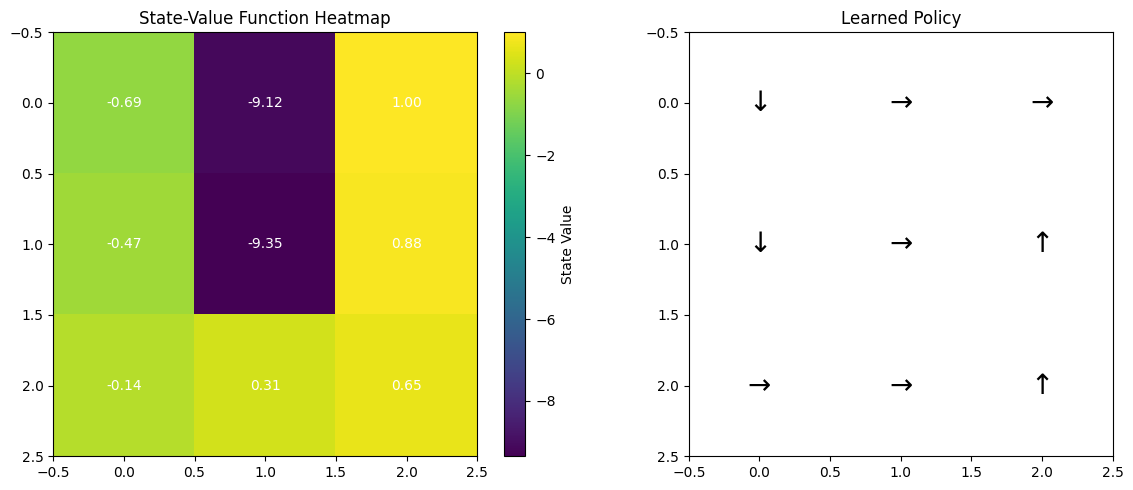

In [17]:
# Visualize the learned policy and value function
trained_model = PPO.load("trained_models/PPO_3x3")
grid_size = 3
policy_grid = np.zeros((grid_size, grid_size), dtype=int)
value_grid = np.zeros((grid_size, grid_size))

# Action mapping for arrows
# {0: LEFT, 1: DOWN, 2: RIGHT, 3: UP}
action_arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}

for i in range(grid_size):
    for j in range(grid_size):
        obs = i * grid_size + j
        # Note: The observation must be an array for the model
        action, _ = trained_model.predict(np.array([obs]), deterministic=True)
        policy_grid[i, j] = action[0]
        
        # Get the value from the policy's value function
        # The observation needs to be preprocessed by the policy
        obs_tensor, _ = trained_model.policy.obs_to_tensor(np.array([obs]))
        value = trained_model.policy.predict_values(obs_tensor)
        value_grid[i, j] = value.item()

# Plot Value Function Heatmap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(value_grid, cmap='viridis')
plt.title('State-Value Function Heatmap')
plt.colorbar(label='State Value')
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, f'{value_grid[i, j]:.2f}', ha='center', va='center', color='white')

# Plot Policy
plt.subplot(1, 2, 2)
plt.imshow(np.zeros_like(policy_grid), cmap='bone_r')
plt.title('Learned Policy')
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, action_arrows.get(policy_grid[i, j], ' '), ha='center', va='center', color='black', fontsize=20)

plt.tight_layout()
plt.show()

In [18]:
policy_grid

array([[1, 2, 2],
       [1, 2, 3],
       [2, 2, 3]])